<a href="https://www.kaggle.com/code/mdmostakimahmedsakib/notebook323c75bfa2?scriptVersionId=297826644" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [10]:
# -*- coding: utf-8 -*-
"""Disentangled_Multimodal_JEPA.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1ABC123...
"""

# Install required libraries
!pip install torch torchvision transformers pillow matplotlib scikit-learn --quiet

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from transformers import DistilBertModel, DistilBertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import random
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Set device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [11]:
# ============================================
# Synthetic Reasoning Dataset
# ============================================

class SyntheticReasoningDataset(Dataset):
    """
    A synthetic dataset containing images and text with reasoning relationships.
    """
    
    def __init__(self, num_samples=1000, img_size=224):
        self.num_samples = num_samples
        self.img_size = img_size
        
        # Image transforms
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Colors and shapes
        self.colors = ['red', 'blue', 'green', 'yellow']
        self.shapes = ['square', 'circle', 'triangle']
        self.color_map = {'red': (255,0,0), 'blue': (0,0,255), 
                         'green': (0,255,0), 'yellow': (255,255,0)}
        
        # Generate dataset
        self.data = self._generate_dataset()
    
    def _generate_dataset(self):
        """Generate the entire dataset"""
        dataset = []
        for i in range(self.num_samples):
            # Randomly create a situation
            num_objects = random.randint(2, 5)
            objects = []
            
            for _ in range(num_objects):
                color = random.choice(self.colors)
                shape = random.choice(self.shapes)
                objects.append({'color': color, 'shape': shape})
            
            # Randomly select question type
            question_type = random.choice(['count', 'color', 'position'])
            
            if question_type == 'count':
                # How many objects of a certain shape?
                target_shape = random.choice(self.shapes)
                count = sum(1 for obj in objects if obj['shape'] == target_shape)
                question = f"How many {target_shape}s are there?"
                answer = str(count)
                
            elif question_type == 'color':
                # What is the color of a specific object?
                target_idx = random.randint(0, num_objects-1)
                question = f"What is the color of object {target_idx+1}?"
                answer = objects[target_idx]['color']
                
            else:  # position
                # What is on the left/right?
                direction = random.choice(['left', 'right'])
                # Simplified for demo
                question = f"What is on the {direction} side?"
                answer = f"Something on {direction}"
            
            # Create text description
            desc_parts = []
            for idx, obj in enumerate(objects):
                desc_parts.append(f"{obj['color']} {obj['shape']}")
            description = " and ".join(desc_parts)
            description += "."
            
            # Save data point
            dataset.append({
                'id': i,
                'objects': objects,
                'description': description,
                'question': question,
                'answer': answer,
                'question_type': question_type
            })
        
        return dataset
    
    def _draw_shape(self, shape, color_rgb, size=50):
        """Draw a specific shape"""
        img = Image.new('RGB', (size, size), color=(255,255,255))
        draw = ImageDraw.Draw(img)
        
        if shape == 'square':
            draw.rectangle([5,5,size-5,size-5], fill=color_rgb, outline=(0,0,0))
        elif shape == 'circle':
            draw.ellipse([5,5,size-5,size-5], fill=color_rgb, outline=(0,0,0))
        elif shape == 'triangle':
            draw.polygon([(size//2,5), (5,size-5), (size-5,size-5)], 
                        fill=color_rgb, outline=(0,0,0))
        
        return img
    
    def _create_image(self, objects):
        """Create an image from a list of objects"""
        num_objects = len(objects)
        
        # Determine grid size
        grid_size = int(np.ceil(np.sqrt(num_objects)))
        cell_size = 70
        img_size = grid_size * cell_size + 20
        
        full_img = Image.new('RGB', (img_size, img_size), color=(255,255,255))
        
        for idx, obj in enumerate(objects):
            row = idx // grid_size
            col = idx % grid_size
            
            x = col * cell_size + 10
            y = row * cell_size + 10
            
            color_rgb = self.color_map[obj['color']]
            shape_img = self._draw_shape(obj['shape'], color_rgb)
            
            full_img.paste(shape_img, (x, y))
        
        return full_img
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Create image
        image = self._create_image(item['objects'])
        image_tensor = self.transform(image)
        
        # Text: description + question
        text = f"{item['description']} {item['question']}"
        
        # Answer (for evaluation only)
        answer = item['answer']
        
        return {
            'image': image_tensor,
            'text': text,
            'answer': answer,
            'question_type': item['question_type'],
            'idx': idx
        }


# Create dataset
print("Creating dataset...")
dataset = SyntheticReasoningDataset(num_samples=500)
print(f"Total samples in dataset: {len(dataset)}")

# View a sample
sample = dataset[0]
print(f"\nSample data:")
print(f"Text: {sample['text']}")
print(f"Answer: {sample['answer']}")
print(f"Image shape: {sample['image'].shape}")

# Split dataset (train/test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Creating dataset...
Total samples in dataset: 500

Sample data:
Text: red triangle and green square. How many squares are there?
Answer: 1
Image shape: torch.Size([3, 224, 224])

Train dataset: 400 samples
Test dataset: 100 samples


In [12]:
# ============================================
# Frozen Encoders
# ============================================

class FrozenEncoders(nn.Module):
    """Pre-trained and frozen encoders"""
    
    def __init__(self):
        super().__init__()
        
        # Vision Encoder (ViT)
        print("Loading ViT encoder...")
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        # Remove classification head, keep feature extractor
        self.vit.heads = nn.Identity()
        # Freeze
        for param in self.vit.parameters():
            param.requires_grad = False
        
        # Text Encoder (DistilBERT)
        print("Loading DistilBERT encoder...")
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        # Freeze
        for param in self.bert.parameters():
            param.requires_grad = False
        
        # Output dimensions
        self.vit_dim = 768  # ViT output dimension
        self.bert_dim = 768  # BERT output dimension
        
        # Projection layers (to same dimension)
        self.img_proj = nn.Linear(self.vit_dim, 256)
        self.text_proj = nn.Linear(self.bert_dim, 256)
        
    def encode_image(self, x):
        with torch.no_grad():
            features = self.vit(x)
        return self.img_proj(features)
    
    def encode_text(self, texts):
        with torch.no_grad():
            inputs = self.tokenizer(texts, return_tensors='pt', 
                                   padding=True, truncation=True, 
                                   max_length=32).to(device)
            outputs = self.bert(**inputs)
            # Take [CLS] token representation
            features = outputs.last_hidden_state[:, 0, :]
        return self.text_proj(features)

# Initialize encoders
encoders = FrozenEncoders().to(device)
print("Encoders loaded successfully")

Loading ViT encoder...
Loading DistilBERT encoder...
Encoders loaded successfully


In [13]:
# ============================================
# Gated Disentangler
# ============================================

class GatedDisentangler(nn.Module):
    """
    Splits input representation into Z_shared and Z_specific
    """
    
    def __init__(self, input_dim=256, latent_dim=128):
        super().__init__()
        
        # Gate mechanism (learns which features go where)
        self.gate_network = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()  # Outputs values between 0-1
        )
        
        # Projection to shared space
        self.shared_proj = nn.Linear(input_dim, latent_dim)
        
        # Projection to specific space
        self.specific_proj = nn.Linear(input_dim, latent_dim)
        
    def forward(self, x):
        # Compute gate values
        gate = self.gate_network(x)  # shape: (batch, input_dim)
        
        # Split using gate
        x_shared = gate * x
        x_specific = (1 - gate) * x
        
        # Project
        z_shared = self.shared_proj(x_shared)
        z_specific = self.specific_proj(x_specific)
        
        return z_shared, z_specific, gate


class DisentangledMultimodalJEPA(nn.Module):
    """
    Complete model: Encoders + Disentangler
    """
    
    def __init__(self, encoders, latent_dim=128):
        super().__init__()
        
        self.encoders = encoders
        
        # Disentangler for images
        self.img_disentangler = GatedDisentangler(
            input_dim=256, latent_dim=latent_dim
        )
        
        # Disentangler for text
        self.text_disentangler = GatedDisentangler(
            input_dim=256, latent_dim=latent_dim
        )
        
        # Temperature parameter (for contrastive loss)
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)
        
    def forward(self, images, texts):
        # Encoding
        img_feat = self.encoders.encode_image(images)  # (batch, 256)
        text_feat = self.encoders.encode_text(texts)  # (batch, 256)
        
        # Disentangling
        img_shared, img_specific, img_gate = self.img_disentangler(img_feat)
        text_shared, text_specific, text_gate = self.text_disentangler(text_feat)
        
        return {
            'img_shared': img_shared,
            'img_specific': img_specific,
            'text_shared': text_shared,
            'text_specific': text_specific,
            'img_gate': img_gate,
            'text_gate': text_gate
        }

# Create model
model = DisentangledMultimodalJEPA(encoders).to(device)
print(f"Model created. Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model created. Total parameters: 152,818,433


In [14]:
# ============================================
# Loss Functions
# ============================================

class ContrastiveLoss(nn.Module):
    """InfoNCE loss - for aligning shared representations"""
    
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, z_img, z_text):
        # Normalize
        z_img = F.normalize(z_img, dim=-1)
        z_text = F.normalize(z_text, dim=-1)
        
        # Similarity matrix
        logits = torch.matmul(z_img, z_text.T) / self.temperature
        
        # Targets (diagonal elements should be 1)
        batch_size = z_img.shape[0]
        labels = torch.arange(batch_size).to(device)
        
        # Loss (cross-entropy)
        loss_img = F.cross_entropy(logits, labels)
        loss_text = F.cross_entropy(logits.T, labels)
        
        return (loss_img + loss_text) / 2


class OrthogonalityLoss(nn.Module):
    """Ensures independence between Z_shared and Z_specific"""
    
    def __init__(self):
        super().__init__()
        
    def forward(self, z_shared, z_specific):
        # Normalize
        z_shared = F.normalize(z_shared, dim=-1)
        z_specific = F.normalize(z_specific, dim=-1)
        
        # Cosine similarity matrix
        sim_matrix = torch.matmul(z_shared, z_specific.T)  # (batch, batch)
        
        # Diagonal elements (same sample) should be zero
        diag_loss = torch.mean(sim_matrix.diag() ** 2)
        
        return diag_loss


class TotalLoss(nn.Module):
    """Combines all losses"""
    
    def __init__(self, lambda_orth=0.1):
        super().__init__()
        self.contrastive = ContrastiveLoss()
        self.orthogonality = OrthogonalityLoss()
        self.lambda_orth = lambda_orth
        
    def forward(self, outputs):
        # Contrastive loss (between shared representations)
        loss_cont = self.contrastive(
            outputs['img_shared'], 
            outputs['text_shared']
        )
        
        # Orthogonality loss (between shared and specific)
        loss_orth_img = self.orthogonality(
            outputs['img_shared'], 
            outputs['img_specific']
        )
        loss_orth_text = self.orthogonality(
            outputs['text_shared'], 
            outputs['text_specific']
        )
        loss_orth = (loss_orth_img + loss_orth_text) / 2
        
        # Total loss
        total_loss = loss_cont + self.lambda_orth * loss_orth
        
        return {
            'total': total_loss,
            'contrastive': loss_cont.item(),
            'orthogonality': loss_orth.item()
        }

In [15]:
# ============================================
# Training Functions
# ============================================

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_losses = {'total': 0.0, 'contrastive': 0.0, 'orthogonality': 0.0}
    
    progress_bar = tqdm(loader, desc='Training')
    for batch in progress_bar:
        images = batch['image'].to(device)
        texts = batch['text']
        
        # Forward pass
        outputs = model(images, texts)
        
        # Calculate loss
        losses = criterion(outputs)   # losses is a dict: 'total' is tensor, others are floats
        
        # Backpropagation
        optimizer.zero_grad()
        losses['total'].backward()    # 'total' is tensor, so .backward() works
        optimizer.step()
        
        # Accumulate losses (convert tensors to float)
        batch_size = images.size(0)
        total_losses['total'] += losses['total'].item() * batch_size
        total_losses['contrastive'] += losses['contrastive'] * batch_size
        total_losses['orthogonality'] += losses['orthogonality'] * batch_size
    
    # Average losses
    num_samples = len(loader.dataset)
    for key in total_losses:
        total_losses[key] /= num_samples
    
    return total_losses 

def evaluate(model, loader):
    """Evaluate model (check retrieval accuracy)"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            images = batch['image'].to(device)
            texts = batch['text']
            
            outputs = model(images, texts)
            
            # Similarity between shared representations
            img_shared = F.normalize(outputs['img_shared'], dim=-1)
            text_shared = F.normalize(outputs['text_shared'], dim=-1)
            
            # Find correct pairs
            sim_matrix = torch.matmul(img_shared, text_shared.T)
            predictions = sim_matrix.argmax(dim=1)
            
            correct += (predictions == torch.arange(len(images)).to(device)).sum().item()
            total += len(images)
    
    accuracy = correct / total
    return accuracy


# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = TotalLoss(lambda_orth=0.1)

# Training
num_epochs = 10
train_losses = []
test_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Test
    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    
    print(f"Train Loss: {train_loss['total']:.4f} (Contra: {train_loss['contrastive']:.4f}, Orth: {train_loss['orthogonality']:.4f})")
    print(f"Test Accuracy: {test_acc:.4f}")

Starting training...

Epoch 1/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Train Loss: 2.7427 (Contra: 2.7426, Orth: 0.0017)
Test Accuracy: 0.2100

Epoch 2/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Train Loss: 2.3108 (Contra: 2.3107, Orth: 0.0011)
Test Accuracy: 0.4100

Epoch 3/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.03it/s]


Train Loss: 1.9934 (Contra: 1.9932, Orth: 0.0012)
Test Accuracy: 0.4400

Epoch 4/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


Train Loss: 1.7235 (Contra: 1.7234, Orth: 0.0011)
Test Accuracy: 0.5900

Epoch 5/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.93it/s]


Train Loss: 1.4907 (Contra: 1.4907, Orth: 0.0009)
Test Accuracy: 0.6600

Epoch 6/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Train Loss: 1.3675 (Contra: 1.3674, Orth: 0.0008)
Test Accuracy: 0.6800

Epoch 7/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]


Train Loss: 1.4293 (Contra: 1.4292, Orth: 0.0007)
Test Accuracy: 0.7400

Epoch 8/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Train Loss: 1.2241 (Contra: 1.2240, Orth: 0.0007)
Test Accuracy: 0.7200

Epoch 9/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]


Train Loss: 1.1386 (Contra: 1.1385, Orth: 0.0007)
Test Accuracy: 0.7800

Epoch 10/10


Evaluating: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

Train Loss: 1.0419 (Contra: 1.0418, Orth: 0.0008)
Test Accuracy: 0.7800


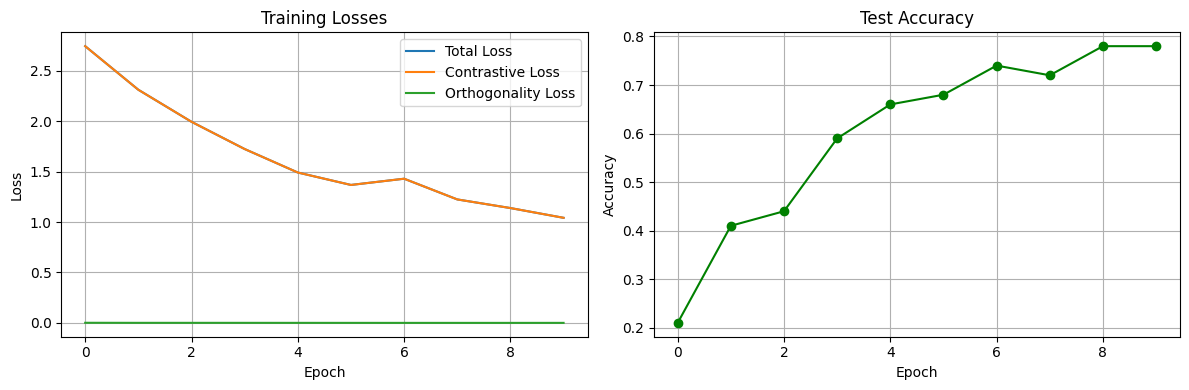

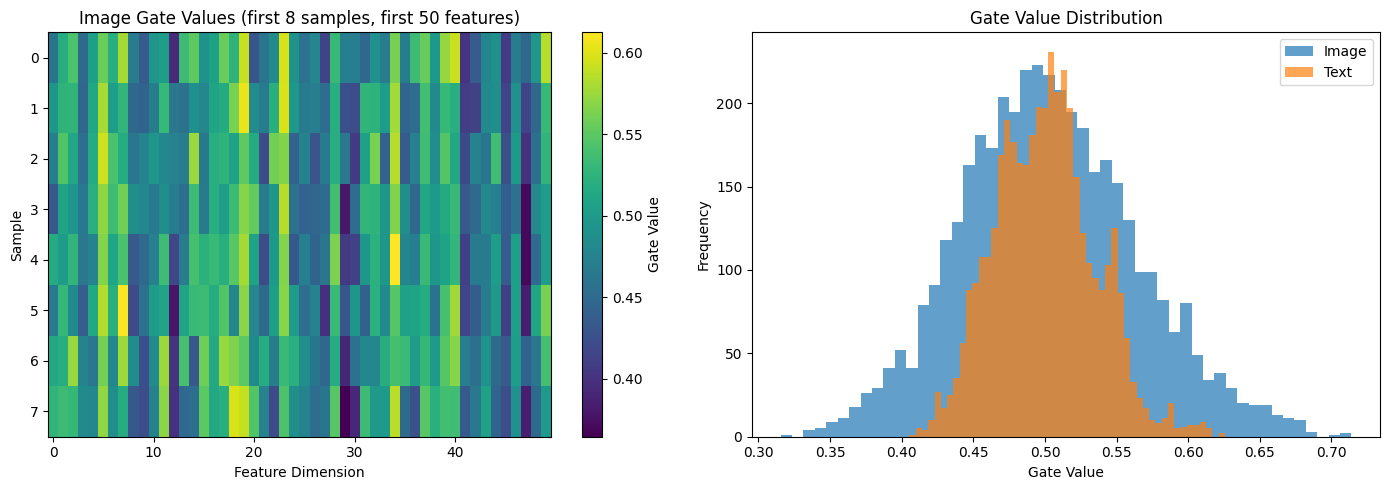

Image gate mean: 0.5031
Text gate mean: 0.5004


In [16]:
# ============================================
# Visualization (fixed)
# ============================================

# Plot losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# train_losses now contains floats for all keys
plt.plot([t['total'] for t in train_losses], label='Total Loss')
plt.plot([t['contrastive'] for t in train_losses], label='Contrastive Loss')
plt.plot([t['orthogonality'] for t in train_losses], label='Orthogonality Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Gate value analysis (already correct, but included for completeness)
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader))
    images = sample_batch['image'].to(device)
    texts = sample_batch['text']
    
    outputs = model(images, texts)
    
    img_gate = outputs['img_gate'].cpu().numpy()   # moved to CPU
    text_gate = outputs['text_gate'].cpu().numpy()
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_gate[:8, :50], aspect='auto', cmap='viridis')
    plt.colorbar(label='Gate Value')
    plt.xlabel('Feature Dimension')
    plt.ylabel('Sample')
    plt.title('Image Gate Values (first 8 samples, first 50 features)')
    
    plt.subplot(1, 2, 2)
    plt.hist(img_gate.flatten(), bins=50, alpha=0.7, label='Image')
    plt.hist(text_gate.flatten(), bins=50, alpha=0.7, label='Text')
    plt.xlabel('Gate Value')
    plt.ylabel('Frequency')
    plt.title('Gate Value Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Image gate mean: {img_gate.mean():.4f}")
    print(f"Text gate mean: {text_gate.mean():.4f}")

In [17]:
# ============================================
# Cross-Modal Transfer Test
# ============================================

class TransferClassifier(nn.Module):
    """Classifier using Z_shared"""
    
    def __init__(self, latent_dim=128, num_classes=4):  # 4 colors
        super().__init__()
        self.classifier = nn.Linear(latent_dim, num_classes)
        
    def forward(self, z):
        return self.classifier(z)


def train_transfer(model, train_loader, mode='image'):
    """
    mode='image': train on image Z_shared
    mode='text': train on text Z_shared
    """
    classifier = TransferClassifier().to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Label mapping for colors
    color_to_label = {'red': 0, 'blue': 1, 'green': 2, 'yellow': 3}
    
    model.eval()
    classifier.train()
    
    for epoch in range(5):  # Train for 5 epochs
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in tqdm(train_loader, desc=f'Transfer Training (Epoch {epoch+1})'):
            images = batch['image'].to(device)
            texts = batch['text']
            answers = batch['answer']
            
            # Create labels
            labels = torch.tensor([color_to_label.get(ans, 0) for ans in answers]).to(device)
            
            with torch.no_grad():
                outputs = model(images, texts)
                
                if mode == 'image':
                    z = outputs['img_shared']
                else:
                    z = outputs['text_shared']
            
            # Classification
            pred = classifier(z)
            loss = criterion(pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (pred.argmax(1) == labels).sum().item()
            total += len(labels)
        
        accuracy = correct / total
        print(f"Mode: {mode}, Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")
    
    return classifier


def test_transfer(classifier, model, test_loader, mode='text'):
    """Test trained classifier on the other modality"""
    color_to_label = {'red': 0, 'blue': 1, 'green': 2, 'yellow': 3}
    
    model.eval()
    classifier.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Transfer Test'):
            images = batch['image'].to(device)
            texts = batch['text']
            answers = batch['answer']
            
            labels = torch.tensor([color_to_label.get(ans, 0) for ans in answers]).to(device)
            
            outputs = model(images, texts)
            
            if mode == 'image':
                z = outputs['img_shared']
            else:
                z = outputs['text_shared']
            
            pred = classifier(z)
            correct += (pred.argmax(1) == labels).sum().item()
            total += len(labels)
    
    accuracy = correct / total
    return accuracy


# Transfer Test
print("\n" + "="*50)
print("CROSS-MODAL TRANSFER TEST")
print("="*50)

# 1. Train on image, test on text
print("\n1. Train on image Z_shared → Test on text Z_shared")
classifier_img = train_transfer(model, train_loader, mode='image')
acc_img_to_text = test_transfer(classifier_img, model, test_loader, mode='text')
print(f"Transfer Accuracy (Image→Text): {acc_img_to_text:.4f}")

# 2. Train on text, test on image
print("\n2. Train on text Z_shared → Test on image Z_shared")
classifier_text = train_transfer(model, train_loader, mode='text')
acc_text_to_img = test_transfer(classifier_text, model, test_loader, mode='image')
print(f"Transfer Accuracy (Text→Image): {acc_text_to_img:.4f}")

# Comparison
print("\n" + "="*50)
print("SUMMARY RESULTS")
print("="*50)
print(f"Image → Text Transfer: {acc_img_to_text:.4f}")
print(f"Text → Image Transfer: {acc_text_to_img:.4f}")


CROSS-MODAL TRANSFER TEST

1. Train on image Z_shared → Test on text Z_shared


Transfer Training (Epoch 1): 100%|██████████| 25/25 [00:05<00:00,  4.36it/s]


Mode: image, Epoch 1, Loss: 1.3152, Accuracy: 0.6400


Transfer Training (Epoch 2): 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Mode: image, Epoch 2, Loss: 1.2254, Accuracy: 0.7725


Transfer Training (Epoch 3): 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Mode: image, Epoch 3, Loss: 1.1482, Accuracy: 0.7725


Transfer Training (Epoch 4): 100%|██████████| 25/25 [00:05<00:00,  4.32it/s]


Mode: image, Epoch 4, Loss: 1.0821, Accuracy: 0.7725


Transfer Training (Epoch 5): 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]


Mode: image, Epoch 5, Loss: 1.0268, Accuracy: 0.7725


Transfer Test: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Transfer Accuracy (Image→Text): 0.7000

2. Train on text Z_shared → Test on image Z_shared


Transfer Training (Epoch 1): 100%|██████████| 25/25 [00:05<00:00,  4.30it/s]


Mode: text, Epoch 1, Loss: 1.4028, Accuracy: 0.0725


Transfer Training (Epoch 2): 100%|██████████| 25/25 [00:05<00:00,  4.34it/s]


Mode: text, Epoch 2, Loss: 1.3483, Accuracy: 0.5000


Transfer Training (Epoch 3): 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Mode: text, Epoch 3, Loss: 1.2966, Accuracy: 0.7675


Transfer Training (Epoch 4): 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


Mode: text, Epoch 4, Loss: 1.2476, Accuracy: 0.7725


Transfer Training (Epoch 5): 100%|██████████| 25/25 [00:05<00:00,  4.39it/s]


Mode: text, Epoch 5, Loss: 1.2022, Accuracy: 0.7725


Transfer Test: 100%|██████████| 7/7 [00:01<00:00,  4.88it/s]

Transfer Accuracy (Text→Image): 0.6200

SUMMARY RESULTS
Image → Text Transfer: 0.7000
Text → Image Transfer: 0.6200


In [ ]:
# ============================================
# Ablation Study
# ============================================

def test_representation(model, loader, rep_type='shared'):
    """
    Test performance of different representations
    rep_type: 'shared', 'specific', 'full'
    """
    color_to_label = {'red': 0, 'blue': 1, 'green': 2, 'yellow': 3}
    
    model.eval()
    
    # Train a small classifier
    if rep_type == 'full':
        classifier = nn.Linear(256, 4).to(device)
    else:
        classifier = nn.Linear(128, 4).to(device)
        
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    # Train
    for epoch in range(5):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in loader:
            images = batch['image'].to(device)
            texts = batch['text']
            answers = batch['answer']
            
            labels = torch.tensor([color_to_label.get(ans, 0) for ans in answers]).to(device)
            
            with torch.no_grad():
                outputs = model(images, texts)
                
                if rep_type == 'shared':
                    z = outputs['img_shared']  # Only image shared
                elif rep_type == 'specific':
                    z = outputs['img_specific']  # Only specific
                elif rep_type == 'full':
                    z = torch.cat([outputs['img_shared'], outputs['img_specific']], dim=1)
            
            pred = classifier(z)
            loss = criterion(pred, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += (pred.argmax(1) == labels).sum().item()
            total += len(labels)
    
    train_acc = correct / total
    
    # Test
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            texts = batch['text']
            answers = batch['answer']
            
            labels = torch.tensor([color_to_label.get(ans, 0) for ans in answers]).to(device)
            
            outputs = model(images, texts)
            
            if rep_type == 'shared':
                z = outputs['img_shared']
            elif rep_type == 'specific':
                z = outputs['img_specific']
            elif rep_type == 'full':
                z = torch.cat([outputs['img_shared'], outputs['img_specific']], dim=1)
            
            pred = classifier(z)
            correct += (pred.argmax(1) == labels).sum().item()
            total += len(labels)
    
    test_acc = correct / total
    
    return {'train_acc': train_acc, 'test_acc': test_acc}


print("\n" + "="*50)
print("ABLATION STUDY")
print("="*50)

# Test three different representations
rep_types = ['shared', 'specific', 'full']
results = {}

for rep_type in rep_types:
    print(f"\nTesting {rep_type.upper()} representation...")
    results[rep_type] = test_representation(model, test_loader, rep_type)
    print(f"Train Accuracy: {results[rep_type]['train_acc']:.4f}")
    print(f"Test Accuracy: {results[rep_type]['test_acc']:.4f}")

# Comparison graph
plt.figure(figsize=(10, 6))
x = np.arange(len(rep_types))
width = 0.35

train_accs = [results[r]['train_acc'] for r in rep_types]
test_accs = [results[r]['test_acc'] for r in rep_types]

plt.bar(x - width/2, train_accs, width, label='Train Accuracy', color='skyblue')
plt.bar(x + width/2, test_accs, width, label='Test Accuracy', color='lightcoral')
plt.xlabel('Representation Type')
plt.ylabel('Accuracy')
plt.title('Ablation Study: Different Representations')
plt.xticks(x, rep_types)
plt.legend()
plt.grid(True, alpha=0.3)

for i, (train, test) in enumerate(zip(train_accs, test_accs)):
    plt.text(i - width/2, train + 0.01, f'{train:.2f}', ha='center', va='bottom')
    plt.text(i + width/2, test + 0.01, f'{test:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nCONCLUSION:")
if results['shared']['test_acc'] > results['specific']['test_acc']:
    print("✓ Z_shared (shared representation) performs better than Z_specific.")
    print("  This proves that features capturing core meaning are important for transfer.")
else:
    print("⚠ Z_specific unexpectedly performs better. Further analysis needed.")